In [3]:
from nilearn import plotting
from nilearn.image import resample_img, mean_img
from nilearn import datasets
import nibabel as nib
from nipype.interfaces import fsl
from nipype.interfaces.ants import N4BiasFieldCorrection

atlas_folder = "/mnt/sharedJH/atlas"
data_test_folder = '/media/harryzhang/VolumeWD/NIFTI_Renamed_test'

subject_list = ['540335','540410','540449','570143','570252','570255','570364']


(130, 130, 30)


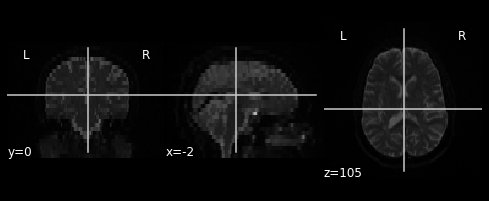

In [4]:
dwi = data_test_folder+'/540335/DWI_b0.nii.gz'
img = nib.load(dwi)
print(img.shape)
plotting.plot_anat(img)

In [10]:
# two run experiment
btr1 = fsl.BET()
btr1.inputs.in_file = data_test_folder+'/540410/DWI_b0.nii.gz'
btr1.inputs.robust = True
btr1.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_first_run.nii.gz'
res = btr1.run()

In [11]:
flt = fsl.FLIRT(bins=640, cost_func='mutualinfo', interp='spline',
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=6)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_first_run.nii.gz'
flt.inputs.reference = atlas_folder+'/mni_icbm152_nlin_asym_09a/mni_icbm152_t2_tal_nlin_asym_09a.nii'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_first_run_r.nii.gz'
flt.inputs.out_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_T2_r_transform.mat'
res = flt.run()

In [18]:
btr2 = fsl.BET()
btr2.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_first_run_r.nii.gz'
btr2.inputs.robust = True
btr2.inputs.frac = 0.5
btr2.inputs.mask = True
btr2.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_second_run_r.nii.gz'
res = btr2.run()

In [13]:
n4 = N4BiasFieldCorrection()
n4.inputs.dimension = 3
n4.inputs.input_image = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_second_run_r.nii.gz'
n4.inputs.bspline_fitting_distance = 300
n4.inputs.shrink_factor = 3
n4.inputs.n_iterations = [50,50,30,20]
n4.inputs.output_image = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_ANTS.nii.gz'
res = n4.run()

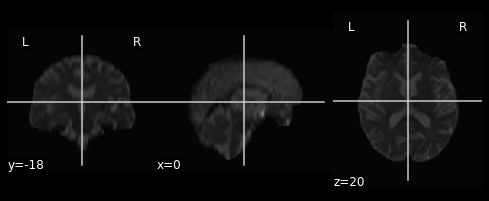

In [9]:
plotting.plot_anat('/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_ANTS.nii.gz')

In [68]:
# robex FSL

flt = fsl.FLIRT(bins=640, cost_func='mutualinfo', interp='spline',
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=6)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_ROBEX_t2_stripped.nii.gz'
flt.inputs.reference = atlas_folder+'/mni_icbm152_nlin_asym_09a/mni_icbm152_t2_tal_nlin_asym_09a.nii'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_ROBEX_t2_stripped_reg.nii.gz'
flt.inputs.out_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_ROBEX_T2_r_transform.mat'
res = flt.run()

In [19]:
# register with dwi
applyxfm = fsl.preprocess.ApplyXFM()
applyxfm.inputs.in_file = data_test_folder+'/540410/DWI_b1000.nii.gz'
applyxfm.inputs.in_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_T2_r_transform.mat'
applyxfm.inputs.out_file =  '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_DWI_ANTS.nii.gz'
applyxfm.inputs.reference = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_ANTS.nii.gz'
applyxfm.inputs.apply_xfm = True
result = applyxfm.run()

In [21]:
am = fsl.maths.ApplyMask()
am.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_DWI_ANTS.nii.gz'
am.inputs.mask_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_second_run_r_mask.nii.gz'
am.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_DWI.nii.gz'
res = am.run() 